In [8]:
import pandas as pd 
import numpy as np
from langdetect import detect
import seaborn as sns
import io 
import matplotlib.pyplot as plt
import boto3
from datetime import datetime as dt
from s3_credentials import *

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [7]:
cd '/Users/admin/Jedha/'

/Users/admin/Jedha


In [9]:
session = boto3.Session(aws_access_key_id= YOUR_ACCESS_KEY, 
                        aws_secret_access_key= YOUR_SECRET_KEY)

s3 = session.resource("s3")
client = session.client("s3")

# full_dataset_reworked
obj = s3.Object('jedha-fake-reviews-project', "datasets/full_dataset.csv")
dataset = pd.read_csv(io.BytesIO(obj.get()['Body'].read()), low_memory = False, index_col=0)

## Cleaning the dataset

In [10]:

######### Cleaning the dataset and adding new columns #########

#we drop rows in which restaurant infos are not available (miss scraped)
dataset = dataset.dropna(subset = ['restaurant_average_rating', 'restaurant_reviews_count', 'restaurant_expensiveness', 'restaurant_name'])
#adding a column with the length of the text review
dataset['text_length'] = dataset['text_review'].apply(lambda x : len(x))


######### Fixing existing columns values and types #########

#for the user_total_image_posted column, if user_total_image_posted is NA it means there's no image found
# so we set the value to 0
dataset.loc[dataset['user_total_image_posted'].isna(), 'user_total_image_posted'] = 0

#for the date column,  there is some miss scrapped data that we want to fix
# a correct data must have a length of 10 , if it is smaller than 10 it's because we scrapped the number of images of the user instead
# we may have to scrap again those lines to fix it
# for now, we keep only the rows where the date is correct 
mask_not_date = dataset['date'].apply(lambda x: len(x)) < 10
dataset = dataset.loc[mask_not_date == False, :]
# if te length is greater than 10 is it is beacause we scraped the date + somme additional words ('Avis mis à jour') so we will keep only the part with the date
mask_date_to_fix = dataset['date'].apply(lambda x: len(x)) > 10
dataset.loc[mask_date_to_fix, 'date' ] = dataset.loc[mask_date_to_fix, 'date' ].str.split('\n').str[0]
#finally we can convert the date column to a datetime format
dataset['date'] = pd.to_datetime(dataset['date'])

#for the language column,
# We set all languages other than fr and eu to other to avoiding having lots of categories (causing troubles with OneHotEncoder)
mask_is_not_fr_en = (dataset['language'] != 'fr') & (dataset['language'] != 'en')
dataset.loc[mask_is_not_fr_en ,'language'] = 'other'

#for the username column,
# Setting Not Yelp User = 'Not_Yelp_User
dataset.loc[dataset['username'] == 'Not Yelp User', 'username' ] = 'Not_Yelp_User'

#for the photos_for_review column, 
# value -1 is in fact 0 (no photos found by the scraper)
dataset.loc[dataset['photos_for_review'] == '-1.0', 'photos_for_review' ] = '0'
# value L is in fact 0 (no photos found by the scraper but scraped the first letter of "L'avis du jour" which happens when the reviews was updated by the user)
dataset.loc[dataset['photos_for_review'] == 'L', 'photos_for_review' ] = '0'
# finally we can convert the photos_for_review column to an int format
dataset['photos_for_review'] = dataset['photos_for_review'].astype('int')

#for the photos_for_review column, 
# when there's no info about the expensiveness we set it to -1
dataset.loc[dataset['restaurant_expensiveness'] == 'N/C', 'restaurant_expensiveness']  = -1
# we can convert the restaurant_expensiveness column to an int format
dataset['restaurant_expensiveness'] = dataset['restaurant_expensiveness'].astype('int')

#for the is_real_review column, 
# when reverse the values 0 and 1 and rename the column is_fake_review it will make our work easier with sklearn features
dataset['is_real_review'] = dataset['is_real_review'].apply(lambda x: 1 if x == 0 else 0)
dataset.rename(columns={'is_real_review': 'is_fake_review'}, inplace=True)


dataset = dataset.reset_index(drop = True)

In [22]:
french_reviews = dataset.loc[dataset['language'] =='fr',:].reset_index(drop=True)

In [23]:
french_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90597 entries, 0 to 90596
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       90597 non-null  datetime64[ns]
 1   username                   90597 non-null  object        
 2   photos_for_review          90597 non-null  int64         
 3   rating                     90597 non-null  float64       
 4   text_review                90597 non-null  object        
 5   user_location              90595 non-null  object        
 6   user_friends_count         90597 non-null  float64       
 7   user_reviews_count         90597 non-null  float64       
 8   user_total_image_posted    90597 non-null  float64       
 9   restaurant_average_rating  90597 non-null  float64       
 10  restaurant_reviews_count   90597 non-null  float64       
 11  restaurant_expensiveness   90597 non-null  int64         
 12  rest

## Analyzing simple statistics 

In [12]:
print('real_review | mean_user_review_count: ', dataset.loc[dataset['is_fake_review']==0, 'user_reviews_count'].mean())
print('fake_review | mean_user_review_count: ', dataset.loc[dataset['is_fake_review']==1, 'user_reviews_count'].mean())
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_user_friend_count: ', dataset.loc[dataset['is_fake_review']==0, 'user_friends_count'].mean())
print('fake_review | mean_user_friend__count: ', dataset.loc[dataset['is_fake_review']==1, 'user_friends_count'].mean())
print( )
print('the high mean in user friend count for fake_review is high due to an extreme value for a specific user which brings a huge bias here ')
print('max value of friends count among the fake reviews : ', dataset.loc[dataset['is_fake_review']==1, 'user_friends_count'].max())
print( )
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_user_image_posted_count: ', dataset.loc[dataset['is_fake_review']==0, 'user_total_image_posted'].mean())
print('fake_review | mean_user_image_posted_count: ', dataset.loc[dataset['is_fake_review']==1, 'user_total_image_posted'].mean())

print( )
print('-----------------------------------------------------------------------------------------')
print('real_review | mean_text_length: ', dataset.loc[dataset['is_fake_review']==0, 'text_length'].mean())
print('fake_review | mean_text_length: ', dataset.loc[dataset['is_fake_review']==1, 'text_length'].mean())



real_review | mean_user_review_count:  94.08211482745956
fake_review | mean_user_review_count:  18.999604030093714
-----------------------------------------------------------------------------------------
real_review | mean_user_friend_count:  43.476652293964825
fake_review | mean_user_friend__count:  228.46671652954376

the high mean in user friend count for fake_review is high due to an extreme value for a specific user which brings a huge bias here 
max value of friends count among the fake reviews :  22811.0

-----------------------------------------------------------------------------------------
real_review | mean_user_image_posted_count:  167.98895523606143
fake_review | mean_user_image_posted_count:  10.800871133793832

-----------------------------------------------------------------------------------------
real_review | mean_text_length:  530.8157211061086
fake_review | mean_text_length:  352.4615249241058


In [15]:
Q1 = np.quantile(dataset['restaurant_reviews_count'], 0.25)
Q3 = np.quantile(dataset['restaurant_reviews_count'], 0.75)

IQR = Q3 - Q1
ext_min = Q1 - 1.5*IQR
ext_max = Q3 + 1.5*IQR

sns.boxplot(dataset_filtered['restaurant_reviews_count'])

## Visualization and Analysis of the features 

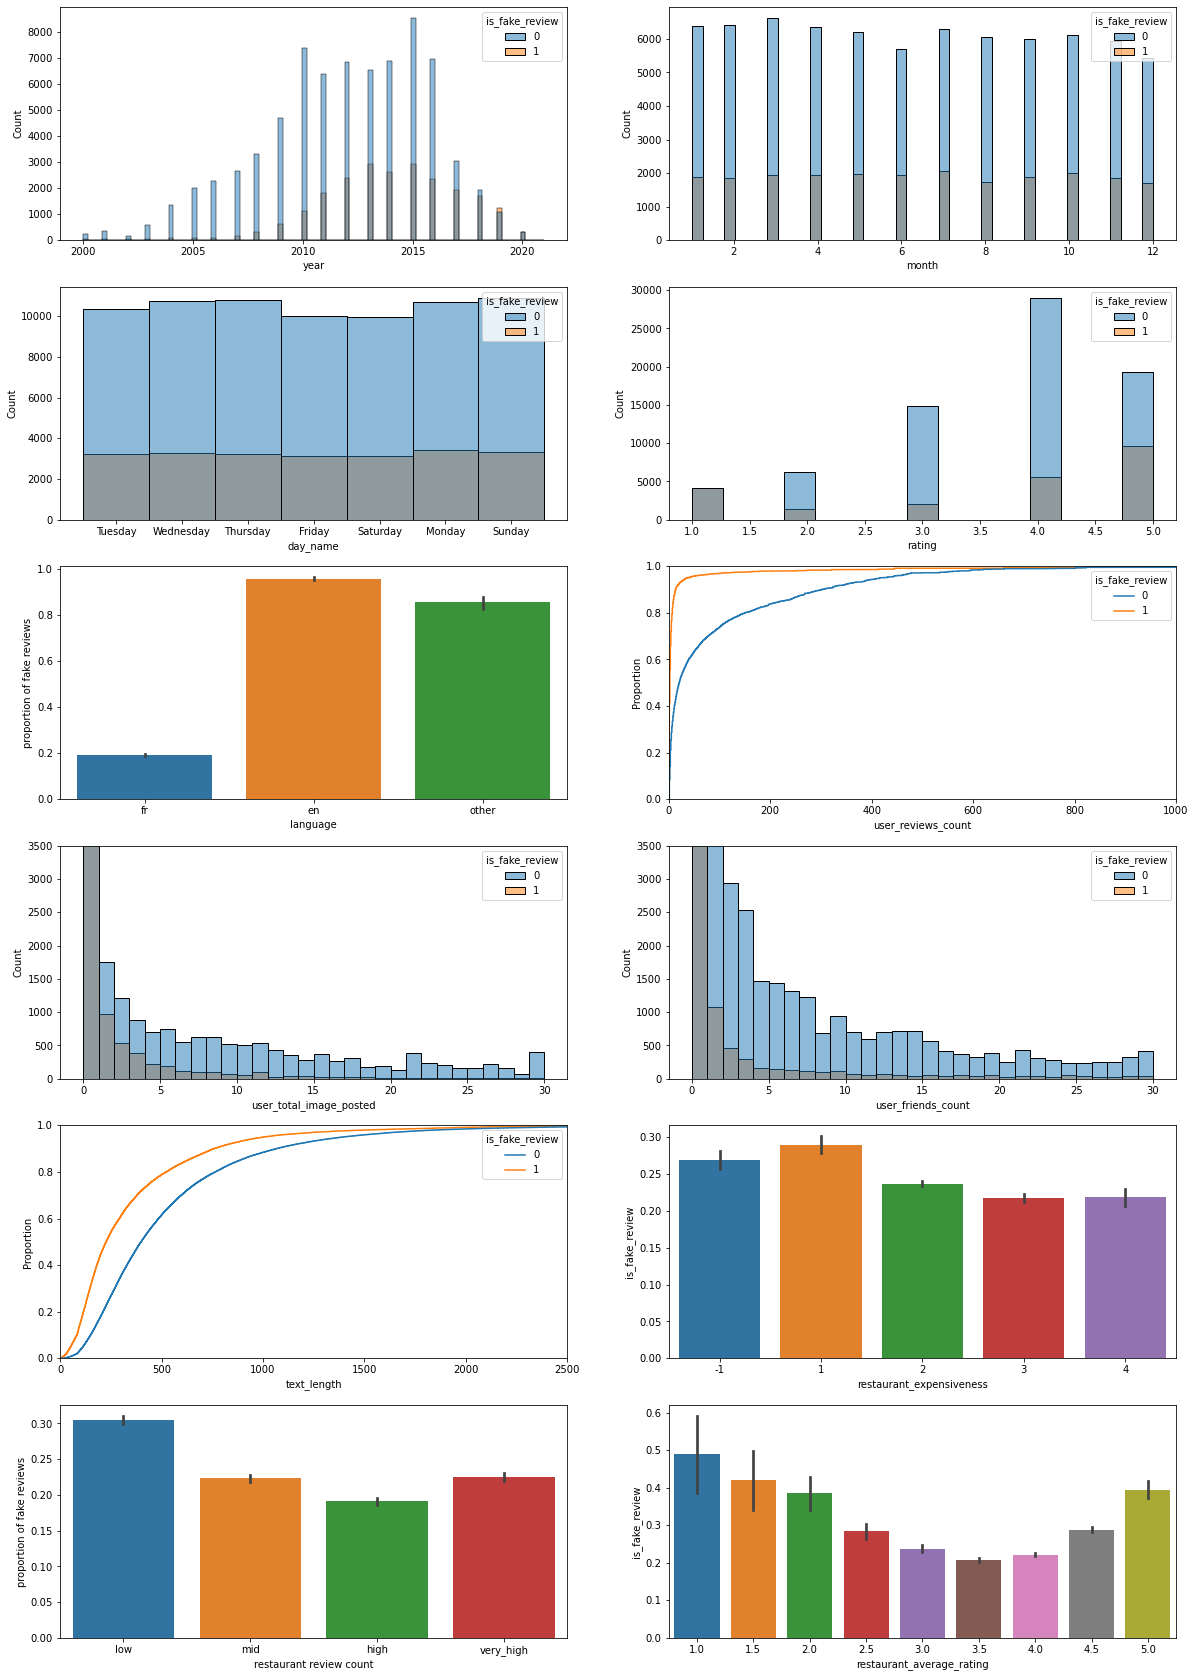

In [17]:
#Creating subdataset for date infos
subdata = pd.DataFrame()
subdata['date'] = dataset['date']
subdata['year'] = subdata['date'].dt.year
subdata['month'] = subdata['date'].dt.month
subdata['day_name'] = subdata['date'].dt.day_name()
subdata['day'] = subdata['date'].dt.day
subdata['is_fake_review'] = dataset['is_fake_review']

#Creating Categories for restaurants review count
review_count_categories = pd.qcut(dataset['restaurant_reviews_count'], 4, labels = ['low', 'mid', 'high', 'very_high'])

fig, ((ax1, ax2), (ax3, ax4) , (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(6,2, figsize=(20,30) )

#setting axes

ax1 = sns.histplot(data = subdata, x = 'year', hue = 'is_fake_review', ax = ax1)
ax2 = sns.histplot(data = subdata, x = 'month', hue = 'is_fake_review', ax = ax2)
ax3 = sns.histplot(data = subdata, x = 'day_name', hue = 'is_fake_review', ax = ax3)

#ax4 = sns.ecdfplot(data = dataset, x ='rating', hue = 'is_fake_review', ax = ax4)
ax4 = sns.histplot(data = dataset, x = 'rating', bins = 15, hue = 'is_fake_review', ax = ax4)
ax5 = sns.barplot(data = dataset, x = 'language', y = 'is_fake_review', ax = ax5)
#ax5 = sns.histplot(data = dataset, x = 'language', hue = 'is_fake_review', ax = ax5)
#ax6 = sns.histplot(x = dataset.loc[dataset['user_reviews_count'] <=200,  'user_reviews_count'], hue = dataset.loc[dataset['user_reviews_count'] <=200, 'is_fake_review'], bins =30, ax = ax6)
ax6 = sns.ecdfplot(data = dataset, x = 'user_reviews_count', hue = 'is_fake_review', ax = ax6)

ax7 = sns.histplot(x = dataset.loc[dataset['user_total_image_posted'] <=30,  'user_total_image_posted'], hue = dataset.loc[dataset['user_total_image_posted'] <=30, 'is_fake_review'], bins =30, ax = ax7)
ax8 = sns.histplot(x = dataset.loc[dataset['user_friends_count'] <=30,  'user_friends_count'], hue = dataset.loc[dataset['user_friends_count'] <=30, 'is_fake_review'], bins =30, ax = ax8)
#ax9 = sns.histplot(data = dataset, x = 'text_length', hue = 'is_fake_review', bins = 100, ax = ax9)
ax9 = sns.ecdfplot(data = dataset, x = 'text_length', hue = 'is_fake_review', ax = ax9) 
#ax10 = sns.histplot(data = dataset, x = 'restaurant_expensiveness', hue = 'is_fake_review', bins = 8, ax = ax10)
ax10 = sns.barplot(data = dataset, x = 'restaurant_expensiveness', y = 'is_fake_review', ax = ax10)
#ax11 = sns.histplot(data = dataset, x = 'restaurant_reviews_count', hue = 'is_fake_review', ax = ax11)
ax11 = sns.barplot(x = review_count_categories, y = dataset['is_fake_review'], ax = ax11 )
#ax12 = sns.histplot(data = dataset, x = 'restaurant_average_rating', bins = 15, hue = 'is_fake_review', ax = ax12)
ax12 = sns.barplot(data = dataset, x = 'restaurant_average_rating', y = 'is_fake_review', ax = ax12)

#setting titles
ax11.set(xlabel='restaurant review count', ylabel= 'proportion of fake reviews')
ax5.set(ylabel= 'proportion of fake reviews')
#setting scales
ax6.set_xlim(0,1000)
ax7.set_ylim(0,3500)
ax8.set_ylim(0,3500)
ax9.set_xlim(0,2500)

#ax9.set_xlim(0,3000)
#ax9.set_ylim(0,2000)
#ax11.set_xlim(0,500)
#ax11.set_ylim(0,2000)

plt.show()

## Some of the features seem to follow a log normal distribution
### might be usefull for Naive Bayes

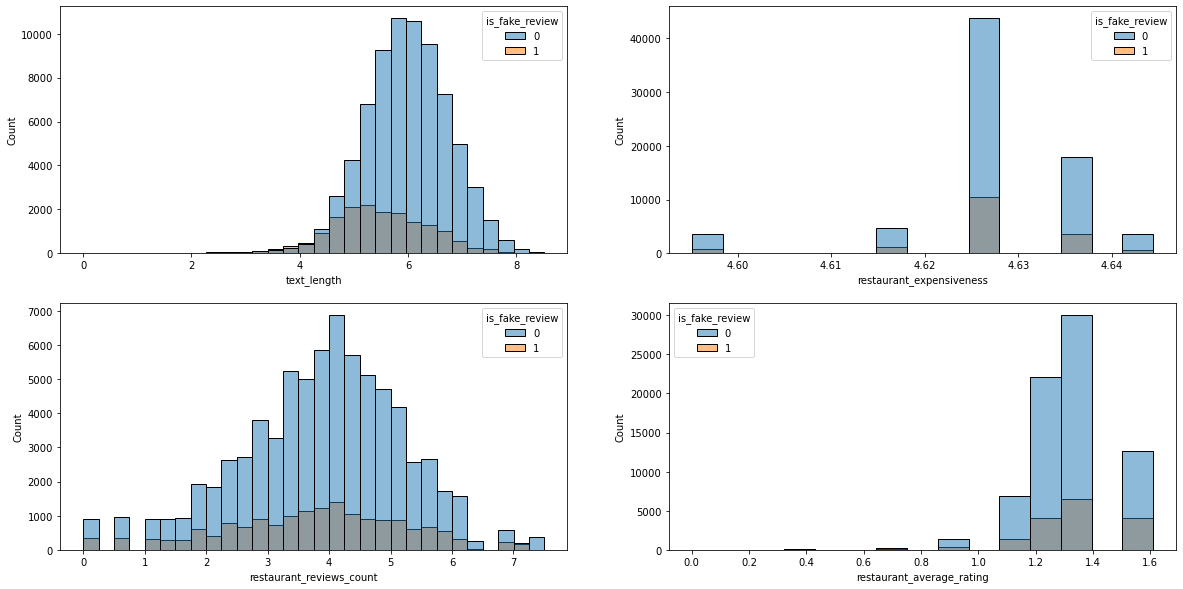

In [223]:
fig, ((ax1, ax2), (ax3, ax4) ) = plt.subplots(2,2, figsize=(20,10) )

#applying the log function makes the data seems like normal distributions
ax1 = sns.histplot(x = np.log(dataset['text_length']), hue = dataset['is_fake_review'], bins =30, ax = ax1)
ax2 = sns.histplot(x = np.log(dataset['restaurant_expensiveness']+100), hue = dataset['is_fake_review'], bins =15, ax = ax2)
ax3 = sns.histplot(x = np.log(dataset['restaurant_reviews_count']), hue = dataset['is_fake_review'], bins =30, ax = ax3)
ax4 = sns.histplot(x = np.log(dataset['restaurant_average_rating']), hue = dataset['is_fake_review'], bins =15, ax = ax4)


plt.show()

## Feature Engineering 

In [104]:
superlatifs = ['bon', 'bonne', 'bons', 'bonnes', 'meilleur', 'meilleure', 'meilleures',
'mauvais', 'mauvaise', 'pire','petit', 'petite', 'moindre','plus', 'mieux', 'gros', 'impossible', 'totalement', 'loin', 'absence', 'très', 'tres', 'décu', 'decu', 'trop', 'jamais', 'toujours', 'aucun', 'déplorable', 'éviter', 'eviter', 'absolument', 'infect', 'infecte', 'fuir', 'fuire']

french_reviews['text_review'] = french_reviews['text_review'].str.replace('\n', ' ')

#adding a column with the text review length
french_reviews['text_length'] = french_reviews['text_review'].apply(lambda x : len(x))

#We then compute the amount of exclamation points within a review, we will discretize it the qcut command
french_reviews['punctuation_count'] = french_reviews['text_review'].apply(lambda x : len(''.join(ch for ch in x if ch =='!' or ch == '?' or ch == '.' or ch =='%')))

#We also compute the amount of uppercase words in a review, we will discretize it with the qcut command
french_reviews['upper_word_count'] = french_reviews['text_review'].apply(lambda x : sum(map(str.isupper, x.split())) )

#Average word length in a tweet
french_reviews['average_word_length'] = french_reviews['text_review'].apply(lambda x : np.mean([len(word) for word in x.split()]) )

#number of digits
french_reviews['digits'] = french_reviews['text_review'].apply(lambda x: len(''.join(ch for ch in x if ch.isnumeric())) )

#Negation
french_reviews['negation'] = french_reviews['text_review'].apply(lambda x :  len([word for word in x.split() if word in ['n', 'ne']]) )

#Count of Superlatives
french_reviews['sup_count'] = french_reviews['text_review'].apply(lambda x :  len([word for word in x.split() if word in superlatifs]) )


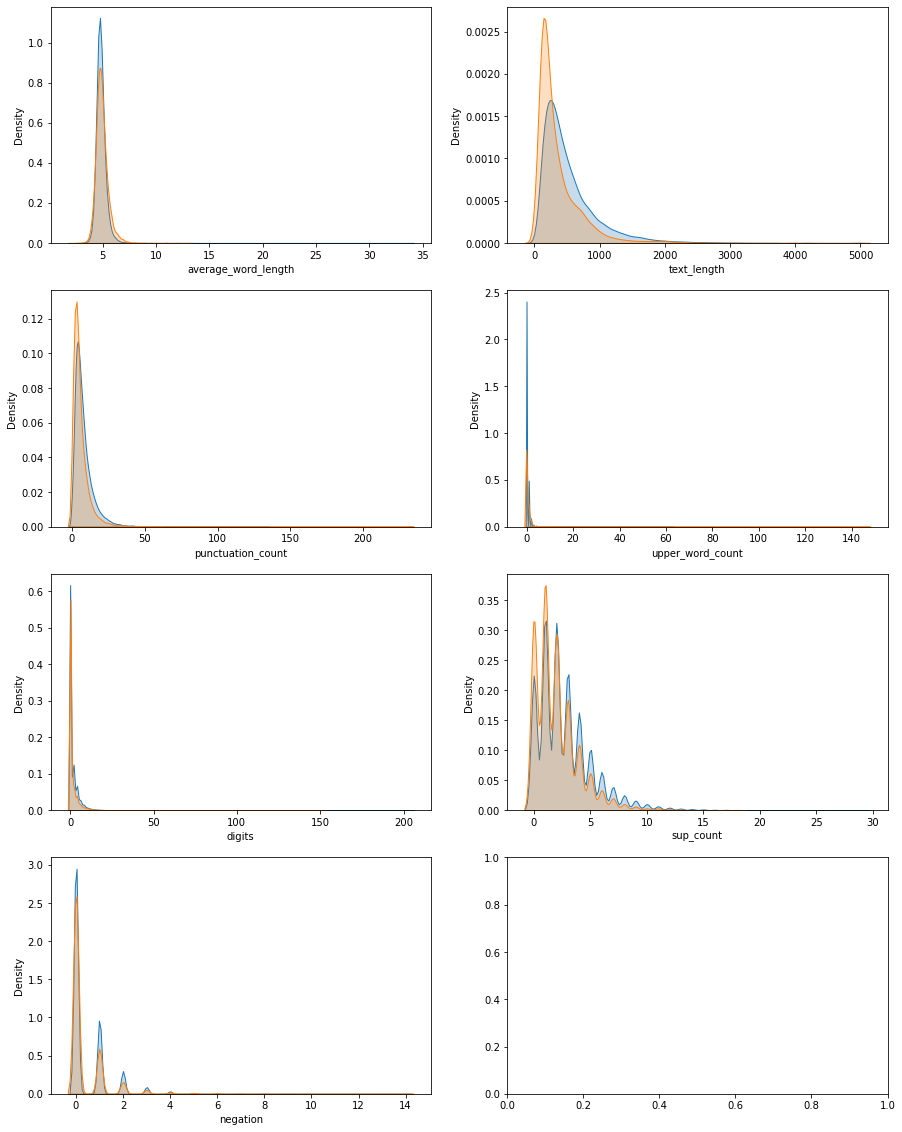

In [20]:
#define subplot to see graphs side by side
fig, ( (ax1,ax2), (ax3, ax4), (ax5,ax6), (ax7, ax8) ) = plt.subplots(4,2, figsize = (15, 20))

#average word length
a=sns.kdeplot(french_reviews['average_word_length'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax1)
a=sns.kdeplot(french_reviews['average_word_length'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax1)

#tweet len
t=sns.kdeplot(french_reviews['text_length'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax2)
t=sns.kdeplot(french_reviews['text_length'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax2)

#word count
e=sns.kdeplot(french_reviews['punctuation_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax3)
e=sns.kdeplot(french_reviews['punctuation_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax3)

#link count
u=sns.kdeplot(french_reviews['upper_word_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax4)
u=sns.kdeplot(french_reviews['upper_word_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax4)


#number of digits
d=sns.kdeplot(french_reviews['digits'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax5)
d=sns.kdeplot(french_reviews['digits'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax5)

#superlatives count
s=sns.kdeplot(french_reviews['sup_count'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax6)
s=sns.kdeplot(french_reviews['sup_count'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax6)

#negations
n=sns.kdeplot(french_reviews['negation'][french_reviews['is_fake_review'] == 0], shade = True, label = 'Not fake', ax= ax7)
n=sns.kdeplot(french_reviews['negation'][french_reviews['is_fake_review'] == 1], shade = True, label = 'Fake', ax = ax7)

#plt.legend()
plt.show()

## Logistic Regression

In [72]:
french_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90597 entries, 0 to 90596
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       90597 non-null  datetime64[ns]
 1   username                   90597 non-null  object        
 2   photos_for_review          90597 non-null  int64         
 3   rating                     90597 non-null  float64       
 4   text_review                90597 non-null  object        
 5   user_location              90595 non-null  object        
 6   user_friends_count         90597 non-null  float64       
 7   user_reviews_count         90597 non-null  float64       
 8   user_total_image_posted    90597 non-null  float64       
 9   restaurant_average_rating  90597 non-null  float64       
 10  restaurant_reviews_count   90597 non-null  float64       
 11  restaurant_expensiveness   90597 non-null  object        
 12  rest

In [103]:
X = french_reviews[[c for c in french_reviews.columns if c not in ['date', 'username', 'text_review', 'user_location', 'restaurant_name', 'url', 'user_total_image_posted', 'language',  'is_fake_review', 'url_not_recommended']]]
y = french_reviews['is_fake_review']
X = X.values
y = np.array(y)

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)

#we use a scaler from sklearn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(C=0.95, class_weight={0:1, 1:2.5}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


model.fit(X_train, y_train)



(90597, 14)


LogisticRegression(C=0.95, class_weight={0: 1, 1: 2.5})

In [98]:
# grid search class weights with logistic regression for imbalance classification

# define grid
#cw_params = [{0:1, 1:1.8}]
cw_params = [{0:1, 1:i} for i in np.arange(2.1, 4.4, 0.1)]
#C_params = np.arange(0.1, 1.1, 0.1)
C_params = [1]
param_grid = dict(class_weight = cw_params, C = C_params)
#param_grid = dict(class_weight = cw_params)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=69)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')
# execute the grid search
grid_result = grid.fit(X_test, y_test)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.542337 using {'C': 1, 'class_weight': {0: 1, 1: 2.5000000000000004}}
0.524481 (0.017587) with: {'C': 1, 'class_weight': {0: 1, 1: 2.1}}
0.534930 (0.016812) with: {'C': 1, 'class_weight': {0: 1, 1: 2.2}}
0.539530 (0.016193) with: {'C': 1, 'class_weight': {0: 1, 1: 2.3000000000000003}}
0.541367 (0.016191) with: {'C': 1, 'class_weight': {0: 1, 1: 2.4000000000000004}}
0.542337 (0.016240) with: {'C': 1, 'class_weight': {0: 1, 1: 2.5000000000000004}}
0.540180 (0.014954) with: {'C': 1, 'class_weight': {0: 1, 1: 2.6000000000000005}}
0.538228 (0.015799) with: {'C': 1, 'class_weight': {0: 1, 1: 2.7000000000000006}}
0.535559 (0.015958) with: {'C': 1, 'class_weight': {0: 1, 1: 2.8000000000000007}}
0.532977 (0.016143) with: {'C': 1, 'class_weight': {0: 1, 1: 2.900000000000001}}
0.530257 (0.014818) with: {'C': 1, 'class_weight': {0: 1, 1: 3.000000000000001}}
0.529151 (0.014192) with: {'C': 1, 'class_weight': {0: 1, 1: 3.100000000000001}}
0.527873 (0.012594) with: {'C': 1, 'class_weight': {0:

In [100]:
print('f1 test :',f1_score(y_test, model.predict(X_test)))
print('f1 train :',f1_score(y_train, model.predict(X_train)))



f1 test : 0.5461546466853991
f1 train : 0.5427245144057468


In [26]:
dataset_fr.to_csv('predictions_meta_data')

In [105]:

print(classification_report(y_true=y_test, y_pred=model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     14643
           1       0.43      0.75      0.55      3477

    accuracy                           0.76     18120
   macro avg       0.68      0.76      0.69     18120
weighted avg       0.83      0.76      0.78     18120



### SVM

In [83]:
from sklearn.svm import SVC

svc_model = SVC(C=1.0, break_ties=False, cache_size=200, class_weight={0:1, 1:2.5}, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)

svc_model.fit(X_train, y_train)

SVC(class_weight={0: 1, 1: 2.4})

In [ ]:
ypred_svc = svc_model.predict(X_test)

print('f1 test :',f1_score(y_test, ypred_svc ))
#print('f1 train :',f1_score(y_train, model.predict(X_train)))

